<a href="https://colab.research.google.com/github/derek-shing/DS-Unit-2-Sprint-4-Model-Validation/blob/master/LS_DS_242_Validate_classification_problems_LIVE_LESSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Model Validation_ 

# Validate classification problems

Objectives
- Classification Metrics: Precision, Recall, F1, ROC AUC
- Confusion Matrix
- Imbalanced Classes


Reading
- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- [ROC curves and Area Under the Curve explained](https://www.dataschool.io/roc-curves-and-auc-explained/)

## Preliminary setup

#### Install [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding)
- Google Colab: `pip install category_encoders`
- Local, Anaconda: `conda install -c conda-forge category_encoders`

#### Install  [mlxtend](http://rasbt.github.io/mlxtend/) to plot decision regions
- Google Colab: Already installed
- Local, Anaconda: `conda install -c conda-forge mlxtend`

#### Get the Bank Marketing dataset from Kaggle ...
- Download from the [Kaggle competition page](https://www.kaggle.com/c/ds2-model-validation/data)
- Or use the Kaggle API

#### ... or from GitHub
- Clone the [repo](https://github.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/tree/master/module-1-begin-modeling-process/bank-marketing)
- Or download from the repo:

In [0]:
 !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_features.csv
 !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_labels.csv
 !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/test_features.csv
 !wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/sample_submission.csv

In [3]:
 !pip install category_encoders

    100% |████████████████████████████████| 61kB 2.4MB/s 


# Classification Metrics & Confusion Matrix — with Bank Marketing dataset

In [0]:
# (Code from the previous notebook)

# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load data
X_train = pd.read_csv('train_features.csv').drop(columns='id')
X_test  = pd.read_csv('test_features.csv').drop(columns='id')
y_train = pd.read_csv('train_labels.csv')['y']
sample_submission = pd.read_csv('sample_submission.csv')

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

#### scikit-learn documentation
- [sklearn.linear_model.LogisticRegression.predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)
- [sklearn.metrics.classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
- [sklearn.model_selection.cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

In [21]:
y_pred_proba

array([0.0733274 , 0.04161109, 0.04878777, ..., 0.05844843, 0.10222659,
       0.04213551])

#### Change the threshold and re-run this cell

In [0]:
threshold = 0.5
y_pred = y_pred_proba >= threshold

print(classification_report(y_train, y_pred))

pd.DataFrame(confusion_matrix(y_train, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     27411
           1       0.65      0.23      0.34      3480

   micro avg       0.90      0.90      0.90     30891
   macro avg       0.78      0.61      0.64     30891
weighted avg       0.88      0.90      0.88     30891



,Predicted Negative,Predicted Positive
Actual Negative,26990,421
Actual Positive,2690,790


In [0]:
#TODO 
true_negative  = 26990
false_positive = 421
false_negative = 2690
true_positive  = 790

actual_negative = true_negative + false_negative
actual_positive = true_positive + false_positive

predicted_negative = 26990 +2690
predicted_positive = 421 +790

precision = true_positive/predicted_positive
recall = true_positive/actual_positive
# f1 = 

#### ROC Curve
- [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- [sklearn.metrics.roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)

Area under the Receiver Operating Characteristic curve: 0.7868824318368706


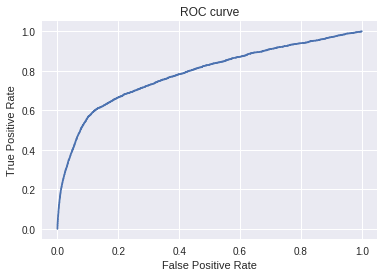

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

# Imbalanced Classes — with synthetic data

## Fun demo!

The next code cell does five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [0]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        96
           1       1.00      0.50      0.67         4

   micro avg       0.98      0.98      0.98       100
   macro avg       0.99      0.75      0.83       100
weighted avg       0.98      0.98      0.98       100

accuracy 0.98


,Predicted Negative,Predicted Positive
Actual Negative,96,0
Actual Positive,2,2


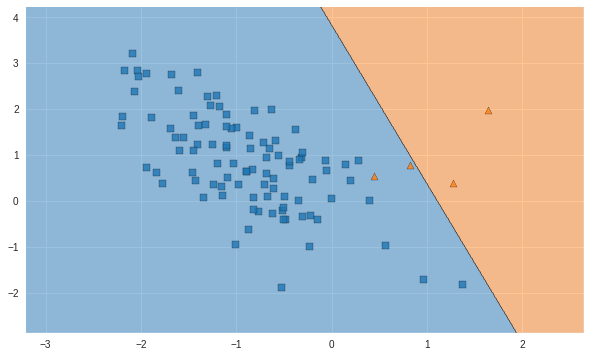

In [55]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = None

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))
display(pd.DataFrame(
    confusion_matrix(y_val, y_pred), 
    columns=['Predicted Negative', 'Predicted Positive'], 
    index=['Actual Negative', 'Actual Positive']))


# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{0: 1, 1: 2}`
- `{0: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{0: 1, 1: 100}`
- `{0: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.


#### We demonstrated two of these options: 

- "Adjust the class weight (misclassification costs)" — many scikit-learn classifiers have a `class_balance` parameter
- "Adjust the decision threshold" — you can lean more about this in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

#### Another option to be aware of:
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."

# ASSIGNMENT

#### Bank Marketing
- Make another submission on Kaggle.
- Try "Cross-Validation + Independent Test Set" instead of "Train/Validate/Test Split."
- Explore and visualize your data. 
- Wrangle [bad data](https://github.com/Quartz/bad-data-guide), outliers, and missing values.
- Try engineering more features. You can transform, bin, and combine features. 
- Try using less features. You can look at multicollinearity. 
- Try the `class_weight` parameter.

#### Imbalanced Classes demo with synthetic data
- Play around with the demo. Change parameter values.
- Be able to calculate precision, recall, F1, and accuracy "by hand", given a confusion matrix and access to Wikipedia.

# STRETCH
- Read the blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415). You can replicate the code as-is,  ["the hard way"](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit). Or you can apply it to the Bank Marketing dataset.
- Try the [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library.
- Try other [scikit-learn classifiers](https://scikit-learn.org/stable/supervised_learning.html), beyond Logistic Regression.

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)




In [0]:
y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

In [0]:
y_train

In [0]:
X_train

In [0]:
m = pipeline.fit(X_train,y_train)

In [65]:
X_train

array([[-1.22893712,  0.85085009],
       [-1.69332707,  1.14110247],
       [-1.93902294,  1.44739877],
       ...,
       [ 0.03587344,  0.62356381],
       [ 0.37456759,  0.14256144],
       [-0.33909283,  0.59547763]])

In [0]:
m.predict(X_train)

In [71]:
m.named_steps['logisticregression'].coef_

array([[-2.49885961e-02, -5.09080999e-03, -5.05844177e-03,
        -3.80634508e-02,  1.23343890e-02,  1.05030974e-02,
         3.08853130e-03, -3.50966897e-03,  6.81324198e-02,
        -9.03856920e-03,  2.65374688e-02,  3.90468998e-03,
         0.00000000e+00,  2.29827562e-02, -9.18735191e-03,
        -2.16375754e-02,  2.12952782e-02,  0.00000000e+00,
        -1.05808055e-03,  2.90106149e-02,  1.41454098e-02,
        -9.67096075e-03, -2.05168500e-02, -3.39415773e-02,
         2.46220216e-02,  1.95617171e-02,  0.00000000e+00,
         4.84339392e-02, -4.55513337e-02, -1.19453064e-01,
         0.00000000e+00, -1.38186852e-02,  1.23665211e-02,
         4.84493784e-03,  0.00000000e+00,  1.43417155e-03,
        -3.30595955e-03,  4.84493784e-03,  0.00000000e+00,
         1.67371939e-01, -1.67371939e-01,  0.00000000e+00,
        -1.38411035e-01, -8.74639230e-02,  8.13717091e-02,
         4.12997305e-02,  3.20084193e-02,  1.82282475e-01,
         4.22473970e-02,  2.08418767e-01, -1.60103300e-0

In [0]:
y_pred_proba= pd.DataFrame(y_pred_proba)

In [41]:
y_pred_proba[0].value_counts()

0    29673
1     1218
Name: 0, dtype: int64

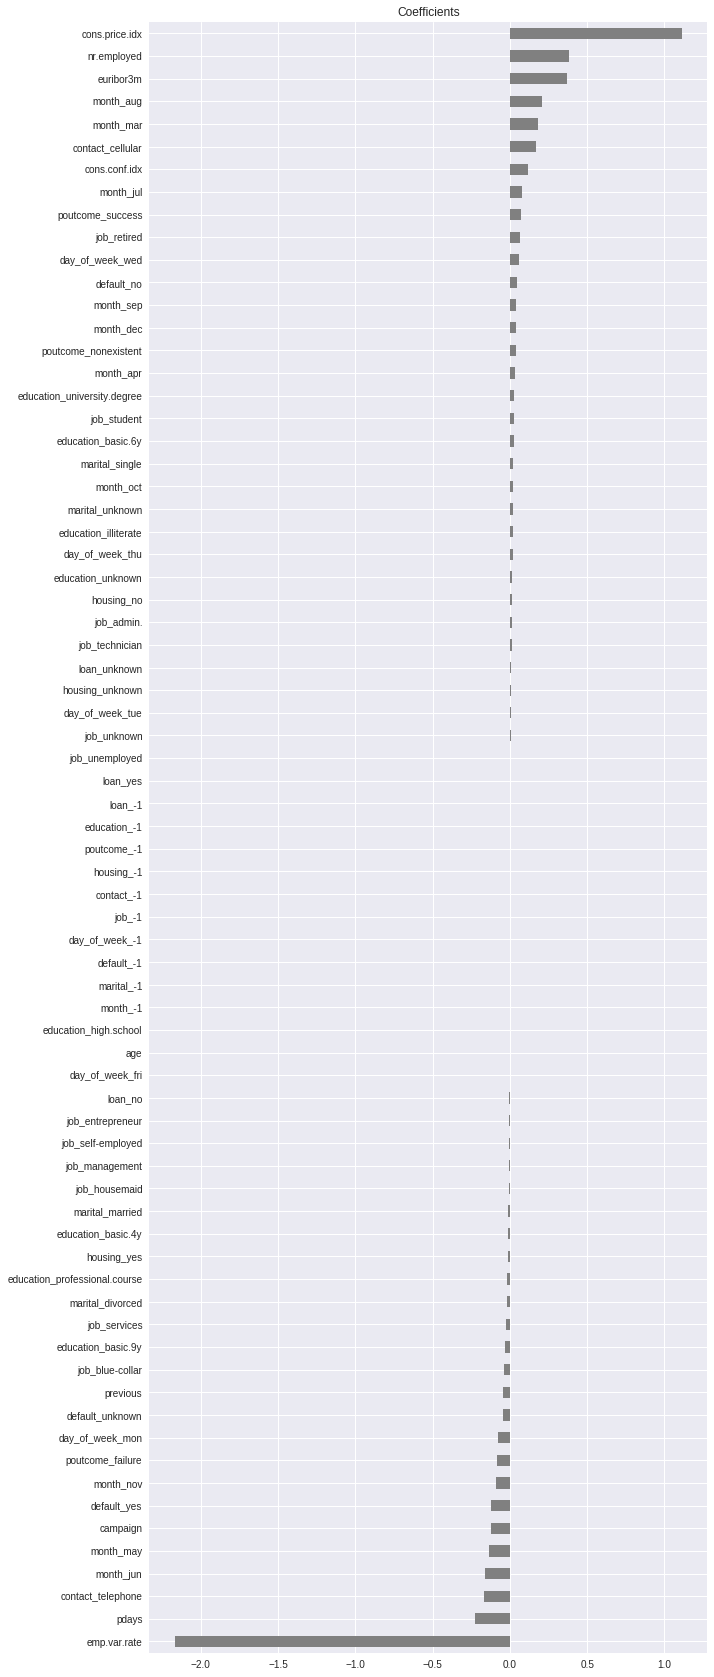

In [72]:
plt.figure(figsize=(10,30))
plt.title('Coefficients')

coefficients = pipeline.named_steps['logisticregression'].coef_[0]
feature_names = pipeline.named_steps['onehotencoder'].transform(X_train).columns
pd.Series(coefficients, feature_names).sort_values().plot.barh(color='gray');